<a href="https://colab.research.google.com/github/meethariprasad/research_works/blob/master/Siamese_TF_Cosine_Distance_Fine_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### Author: Hari Prasad, This work is as part of providing simple examples in the world of complicated examples. Have fun!
###### Licence: Free to Distribute and Modify. You can quote this github reference for sure. :-)

In [31]:
%tensorflow_version 2.x
# !pip install tensorflow==2.1.0rc0
import tensorflow as tf
print (tf.__version__)
import numpy as np

2.1.0-rc1


In [32]:
print ("Following is simple self explatory code of how dot layer works as cosine similiarity between two vectors, if normalize = True set")
tf.keras.backend.set_floatx('float64')
x=np.asarray([-1.,-1.,-1])
x=np.reshape(x,(1,3))
y=np.asarray([1.,1.,1.])
y=np.reshape(y,(1,3))
tf.keras.layers.Dot(axes=-1,normalize=True)([x,y]).numpy()[0][0]

Following is simple self explatory code of how dot layer works as cosine similiarity between two vectors, if normalize = True set


-1.0000000000000002

2.1.0-rc1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          256797824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1)            0           keras_layer[0][0]  

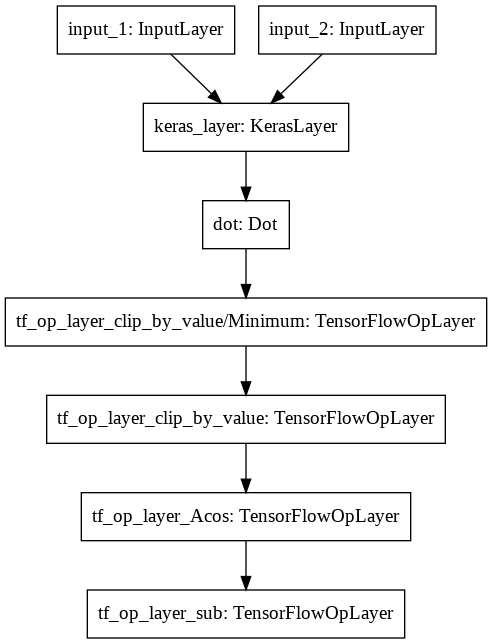

In [33]:
%tensorflow_version 2.x
# !pip install tensorflow==2.1.0rc0
import tensorflow as tf
print (tf.__version__)
tf.keras.backend.clear_session()
import gc
try:
  del model
except:
  pass
gc.collect()
import tensorflow_hub as hub
from tensorflow import keras
import os
import logging
tf.get_logger().setLevel(logging.ERROR)

huburl = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
fine_tuned_module_object = hub.load(huburl)
shared_embedding_layer = hub.KerasLayer(fine_tuned_module_object,trainable=True)

left_input = keras.Input(shape=(), dtype=tf.string)
right_input = keras.Input(shape=(), dtype=tf.string)

embedding_left_output= shared_embedding_layer(left_input)
embedding_right_output= shared_embedding_layer(right_input)

cosine_similiarity=tf.keras.layers.Dot(axes=-1,normalize=True)([embedding_left_output,embedding_right_output])

#We are using acos so that highly similiar sentences can have well 
#seperation. So we are not using:
#cos_distance=1-cosine_similiarity
#https://math.stackexchange.com/questions/2874940/cosine-similarity-vs-angular-distance?newreg=02fd1e16a9164cbba05197b28d353409
clip_cosine_similarities = tf.clip_by_value(cosine_similiarity, -1.0, 1.0)
cos_distance = 1.0 - tf.acos(clip_cosine_similarities)



model = tf.keras.Model([left_input,right_input], cos_distance)
#Define Optimizer
#https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/

# optim = keras.optimizers.RMSprop(clipnorm=1.)
optim =tf.compat.v1.train.ProximalAdagradOptimizer(learning_rate=0.0001
                                                   ,l1_regularization_strength=0.0,
                                                   l2_regularization_strength=0.01
                                                   )
model.compile(optimizer=optim, loss='mse')
model.summary()
tf.keras.utils.plot_model(model, to_file='my_model.png')

### Cosine Distance Target Value Explanation

Cosine similiarity varies between -1 to +1, with -1 being Orthogonally Opposite and +1 being in same direction.

Cosine Distance is 1-(Cosine Similiarity)=>falls under [0,2]

Distance is Highest(Far Apart vectors) at 2, => Cosine Similiarity =-1, 1-(-1)=2

Distance is lowest(Similiar Vectors) at 0, => Cosine Similiarity = 1, 1-(1)=0

Hence if two vectors are similiar, the assignment should be 0, and if they are opposite then it must be 2

This gives us option to rank highly similiar sentences based on notion between 0 to 2.

As gradient loss function minimizes the loss, the 0 loss means the actual cosine distance and calculated are same.

In [34]:
#Inputs
import numpy as np
text_list=[["Man is going to Moon","Education is greatest gift to humanity"],
           ["Man achieved great feat in apollo mission","Literacy is important for civilization"]]

#Model Input Preperation as Numpy array
left_inputs=np.asarray(text_list[0])
right_inputs=np.asarray(text_list[1])
#0 if we inputs are semantically similiar, 2 if not. Anything inbetween 0=2 represent partial similiarity
similiarity=np.asarray([0,0])

left_inputs=left_inputs.reshape(left_inputs.shape[0],)
right_inputs=right_inputs.reshape(right_inputs.shape[0],)

left_inputs.shape,right_inputs.shape,similiarity.shape

((2,), (2,), (2,))

In [0]:
def get_similiarity(target_text_embed,text_to_compare_embed):
    from sklearn.metrics.pairwise import cosine_similarity
    similiarity=cosine_similarity(target_text_embed,text_to_compare_embed)
    similiarity=pd.DataFrame(similiarity)
    return similiarity

In [36]:
#Model Fit
from keras.callbacks import Callback
class stopAtLossValue(Callback):
  import numpy as np
  def on_batch_end(self, batch, logs={}):
    THR = 0 #Assign THR with the value at which you want to stop training.
    if np.around(logs.get('loss'),decimals=1) == THR:
      self.model.stop_training = True

import numpy as np

model.fit([left_inputs,right_inputs],similiarity,epochs=300,callbacks=[stopAtLossValue()])

Train on 2 samples
Epoch 1/300
2/2 [==============================] - 8s 4s/sample - loss: 0.0158


In [37]:
import tensorflow_hub as hub
import tensorflow as tf
print (text_list)
try:
  text_list=sum(text_list, [])
except:
  pass

embeddings = fine_tuned_module_object(text_list)

# print (embeddings.numpy())

embed_target=embeddings.numpy()
import pandas as pd
doc_embed = pd.DataFrame(data=embed_target)
doc_embed.index=text_list



finetuned_similiarity=get_similiarity(doc_embed,doc_embed)
# np.fill_diagonal(sim.values, 0)
finetuned_similiarity.index=text_list
finetuned_similiarity.columns=text_list
print ("With Fine Tune")
finetuned_similiarity

[['Man is going to Moon', 'Education is greatest gift to humanity'], ['Man achieved great feat in apollo mission', 'Literacy is important for civilization']]
With Fine Tune


,Man is going to Moon,Education is greatest gift to humanity,Man achieved great feat in apollo mission,Literacy is important for civilization
Man is going to Moon,1.000000,0.104170,0.422002,0.099235
Education is greatest gift to humanity,0.104170,1.000000,0.163552,0.439987
Man achieved great feat in apollo mission,0.422002,0.163552,1.000000,0.049463
Literacy is important for civilization,0.099235,0.439987,0.049463,1.000000


In [38]:
#Without fine tune: Similiarity
########################################
import tensorflow_hub as hub
import tensorflow as tf
un_tuned_module_object = hub.load(huburl)
try:
  text_list=sum(text_list, [])
except:
  pass
text_list.append('Moon was in astrology of Man')

embeddings = un_tuned_module_object(text_list)

embed_target=embeddings.numpy()
import pandas as pd
doc_embed_global = pd.DataFrame(data=embed_target)
doc_embed_global.index=text_list
########################################
global_similiarity=get_similiarity(doc_embed_global,doc_embed_global)
# np.fill_diagonal(sim.values, 0)
global_similiarity.index=text_list
global_similiarity.columns=text_list

print ("Without Fine Tune")
global_similiarity

Without Fine Tune


,Man is going to Moon,Education is greatest gift to humanity,Man achieved great feat in apollo mission,Literacy is important for civilization,Moon was in astrology of Man
Man is going to Moon,1.000000,0.104139,0.421958,0.099204,0.511980
Education is greatest gift to humanity,0.104139,1.000000,0.163523,0.439952,0.103207
Man achieved great feat in apollo mission,0.421958,0.163523,1.000000,0.049431,0.272311
Literacy is important for civilization,0.099204,0.439952,0.049431,1.000000,0.196779
Moon was in astrology of Man,0.511980,0.103207,0.272311,0.196779,1.000000


In [39]:
print ("Following code can be used to export and reuse the fine tuned module from local system.")
import os
#Set export to true to export fine tuned model to module_export_dir_name
export=False
if (export):
  module_export_dir_name='finetuned_model_export'
  #Creating module export directory in current directory. You can change wherever you need.
  os.makedirs(module_export_dir_name,exist_ok=True)
  export_module_dir = os.path.join(os.getcwd(), module_export_dir_name)
  tf.saved_model.save(fine_tuned_module_object, export_module_dir)
  fine_tuned_module_dir=os.path.join(os.getcwd(),module_export_dir_name)

  loaded_module_obj = hub.load(fine_tuned_module_dir)
  embeddings = loaded_module_obj(text_list)

  embed_target=embeddings.numpy()
  import pandas as pd
  doc_embed = pd.DataFrame(data=embed_target)
  doc_embed.index=text_list


  finetuned_similiarity_loaded=get_similiarity(doc_embed,doc_embed)
  # np.fill_diagonal(sim.values, 0)
  finetuned_similiarity_loaded.index=text_list
  finetuned_similiarity_loaded.columns=text_list
  print ("With Fine Tune and Exported")
  finetuned_similiarity_loaded
else:
  print ("No Export Selected")

Following code can be used to export and reuse the fine tuned module from local system.
No Export Selected


### *Following Sections are reused from Google Universal Sentence Embedding Evaluation. Thanks to TF Hub Authors.*

## Evaluation: STS (Semantic Textual Similarity) Benchmark

The [**STS Benchmark**](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) provides an intristic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is then used to evaluate the quality of the machine similarity scores against human judgements.


### Download data

In [40]:
import pandas
import scipy
import math
import csv

sts_dataset = tf.keras.utils.get_file(
    fname="Stsbenchmark.tar.gz",
    origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
    extract=True)
sts_dev = pandas.read_table(
    os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
    error_bad_lines=False,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
sts_test = pandas.read_table(
    os.path.join(
        os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
    error_bad_lines=False,
    quoting=csv.QUOTE_NONE,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
# cleanup some NaN values in sts_dev
sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]
print (sts_dev.shape,sts_test.shape)
sts_dev.head(5)

(1468, 3) (1379, 3)


,sim,sent_1,sent_2
0,5.00,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.
1,4.75,A young child is riding a horse.,A child is riding a horse.
2,5.00,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.
3,2.40,A woman is playing the guitar.,A man is playing guitar.
4,2.75,A woman is playing the flute.,A man is playing a flute.


### Evaluate Sentence Embeddings for Fine Tuned Module

Fine tuning must not reduce the OOB Module Corelation Score, indicating we have not compromised on generalization.



In [41]:
sts_data = sts_test #@param ["sts_dev", "sts_test"] {type:"raw"}

def run_sts_benchmark(batch,module_object):
  sts_encode1 = tf.nn.l2_normalize(module_object(tf.constant(batch['sent_1'].tolist())), axis=1)
  sts_encode2 = tf.nn.l2_normalize(module_object(tf.constant(batch['sent_2'].tolist())), axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities)
  """Returns the similarity scores"""
  return scores

dev_scores = sts_data['sim'].tolist()
scores = []

module_object=un_tuned_module_object

for batch in np.array_split(sts_data, 10):
  scores.extend(run_sts_benchmark(batch,module_object))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Untuned Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))


##With Fune#
module_object=fine_tuned_module_object
scores = []
for batch in np.array_split(sts_data, 10):
  scores.extend(run_sts_benchmark(batch,module_object))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Fine Tuned Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Untuned Pearson correlation coefficient = 0.7821121693112975
p-value = 3.811544425526969e-285
Fine Tuned Pearson correlation coefficient = 0.7821115248120356
p-value = 3.8183669597899066e-285
